<a href="https://colab.research.google.com/github/javier-jaime/Stock_Price_Forecasting/blob/main/Update11_BTC_Price_Forecasting_with_yfinance_and_Facebook_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bitcoin Price Forecasting with yfinance and Facebook Prophet**

## Importing all the necessary Libraries

In [63]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px
from prophet import Prophet
import plotly.io as pio
import warnings
pio.renderers.default='colab'
warnings.filterwarnings("ignore")

## Importing the Dataset & Exploring it

In [64]:
 # Stock Ticker Input
stock = input('Enter the stock ticker: ')
print(f'You entered {stock}, here is the data from the last 10 days:')
period = '3y'
ticker = yf.Ticker(stock)
data = ticker.history(period)
data.reset_index(inplace=True)
data.tail(10)

Enter the stock ticker: BTC-USD
You entered BTC-USD, here is the data from the last 10 days:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
1086,2024-02-19 00:00:00+00:00,52134.812500,52483.324219,51711.820312,51779.144531,21362184346,0.0,0.0
1087,2024-02-20 00:00:00+00:00,51777.726562,52945.050781,50792.312500,52284.875000,33353758256,0.0,0.0
1088,2024-02-21 00:00:00+00:00,52273.535156,52368.816406,50671.757812,51839.179688,28624907020,0.0,0.0
1089,2024-02-22 00:00:00+00:00,51854.644531,52009.613281,50926.292969,51304.972656,25413900611,0.0,0.0
1090,2024-02-23 00:00:00+00:00,51283.906250,51497.933594,50561.777344,50731.949219,21427078270,0.0,0.0
1091,2024-02-24 00:00:00+00:00,50736.371094,51684.195312,50585.445312,51571.101562,15174077879,0.0,0.0
1092,2024-02-25 00:00:00+00:00,51565.214844,51950.027344,51306.171875,51733.238281,15413239245,0.0,0.0
1093,2024-02-26 00:00:00+00:00,51730.539062,54938.175781,50931.031250,54522.402344,34074411896,0.0,0.0
1094,2024-02-27 00:00:00+00:00,54519.363281,57537.839844,54484.199219,57085.371094,49756832031,0.0,0.0
1095,2024-02-28 00:00:00+00:00,57071.097656,63734.074219,56779.214844,60124.578125,76676153344,0.0,0.0


In [65]:
print('These are the basic stats:')
data.describe()

These are the basic stats:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1096.000000,1096.000000,1096.000000,1096.000000,1.096000e+03,1096.0,1096.0
mean,35140.774779,35897.238009,34327.005954,35150.186807,2.923876e+10,0.0,0.0
std,12667.946132,13023.564596,12275.473842,12680.399959,1.545652e+10,0.0,0.0
min,15782.300781,16253.047852,15599.046875,15787.284180,5.331173e+09,0.0,0.0
25%,24738.201172,25228.042969,24302.009766,24719.875000,1.809879e+10,0.0,0.0
50%,33101.386719,34125.681641,31692.211914,33121.041016,2.675702e+10,0.0,0.0
75%,43858.236328,44516.247070,42818.048828,43847.501953,3.622633e+10,0.0,0.0
max,67549.734375,68789.625000,66382.062500,67566.828125,1.263581e+11,0.0,0.0


# Data Visualization (plotly express) - Visualizing the historical performance

In [66]:
#Line graph (Price), Area graph (Volume) , box plot (Analyzing price and volume)

In [67]:
px.line(data, x="Date", y="Close", title=f'{stock} Stock Close Price')

In [68]:
px.bar(data, x="Date", y="Volume", title=f'{stock} Stock Volume')

In [69]:
px.box(data, y="Close", title=f'{stock} box plot', height=500, width=500)

In [70]:
def get_hurst_exponent(time_series, max_lag=100):
    """Returns the Hurst Exponent of the time series"""
    lags = range(2, max_lag)
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [75]:
hurst = pd.DataFrame(columns =["hurst_exp","lag"])
lags = range(4, 60, 1)
for lag in lags:
    hurst_exp = get_hurst_exponent(data["Close"].values, lag)
    hurst = hurst.append({"hurst_exp":hurst_exp,"lag":lag},ignore_index=True)
warnings.filterwarnings("ignore")
px.line(hurst, x="hurst_exp", y="lag", title=f'{stock} Hurst Exp')

## Data Preparation for Facebook Prophet

In [76]:
columns=['Date','Close']
prophet_df=pd.DataFrame(data,columns=columns)
prophet_df=prophet_df.rename(columns={'Date':'ds','Close':'y'})
prophet_df['ds']=prophet_df['ds'].dt.tz_localize(None)
prophet_df.tail()

,ds,y
1091,2024-02-24,51571.101562
1092,2024-02-25,51733.238281
1093,2024-02-26,54522.402344
1094,2024-02-27,57085.371094
1095,2024-02-28,60124.578125


## Creating Facebook Prophet Model

In [77]:
m=Prophet(daily_seasonality=False)
m.fit(prophet_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmplagdveiu/qr31203r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplagdveiu/nff3hu_g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93469', 'data', 'file=/tmp/tmplagdveiu/qr31203r.json', 'init=/tmp/tmplagdveiu/nff3hu_g.json', 'output', 'file=/tmp/tmplagdveiu/prophet_modelkg6gh2eu/prophet_model-20240228203534.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:35:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:35:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


##Forecasting

In [78]:
periods = 60
future=m.make_future_dataframe(periods)

In [79]:
forecast=m.predict(future)

In [80]:
forecast.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-02-28,51384.572789,49945.441606,57351.887970,51384.572789,51384.572789,2291.141681,2291.141681,2291.141681,-52.183524,-52.183524,-52.183524,2343.325205,2343.325205,2343.325205,0.0,0.0,0.0,53675.714470
1,2021-03-01,51265.436119,49874.619203,57357.535614,51265.436119,51265.436119,2286.245844,2286.245844,2286.245844,3.627985,3.627985,3.627985,2282.617859,2282.617859,2282.617859,0.0,0.0,0.0,53551.681964
2,2021-03-02,51146.299450,49546.922611,57401.301645,51146.299450,51146.299450,2313.788997,2313.788997,2313.788997,66.427189,66.427189,66.427189,2247.361807,2247.361807,2247.361807,0.0,0.0,0.0,53460.088446
3,2021-03-03,51027.162780,49667.573966,56922.141366,51027.162780,51027.162780,2392.860256,2392.860256,2392.860256,151.106361,151.106361,151.106361,2241.753895,2241.753895,2241.753895,0.0,0.0,0.0,53420.023036
4,2021-03-04,50908.026110,49219.723541,56847.663839,50908.026110,50908.026110,2206.826414,2206.826414,2206.826414,-62.515870,-62.515870,-62.515870,2269.342284,2269.342284,2269.342284,0.0,0.0,0.0,53114.852524
5,2021-03-05,50788.889440,49514.669606,56699.009934,50788.889440,50788.889440,2270.768423,2270.768423,2270.768423,-62.177367,-62.177367,-62.177367,2332.945790,2332.945790,2332.945790,0.0,0.0,0.0,53059.657863
6,2021-03-06,50669.752770,49045.092985,56796.750426,50669.752770,50669.752770,2390.306183,2390.306183,2390.306183,-44.284775,-44.284775,-44.284775,2434.590958,2434.590958,2434.590958,0.0,0.0,0.0,53060.058953
7,2021-03-07,50550.616101,49535.644795,56922.644590,50550.616101,50550.616101,2523.284791,2523.284791,2523.284791,-52.183524,-52.183524,-52.183524,2575.468315,2575.468315,2575.468315,0.0,0.0,0.0,53073.900892
8,2021-03-08,50431.479431,49487.307770,57119.590418,50431.479431,50431.479431,2759.536761,2759.536761,2759.536761,3.627985,3.627985,3.627985,2755.908775,2755.908775,2755.908775,0.0,0.0,0.0,53191.016191
9,2021-03-09,50312.342761,49831.304373,57117.910435,50312.342761,50312.342761,3041.807828,3041.807828,3041.807828,66.427189,66.427189,66.427189,2975.380638,2975.380638,2975.380638,0.0,0.0,0.0,53354.150589


In [81]:
px.line(forecast, x='ds',y='yhat', title=f'{stock} Stock Forecast')

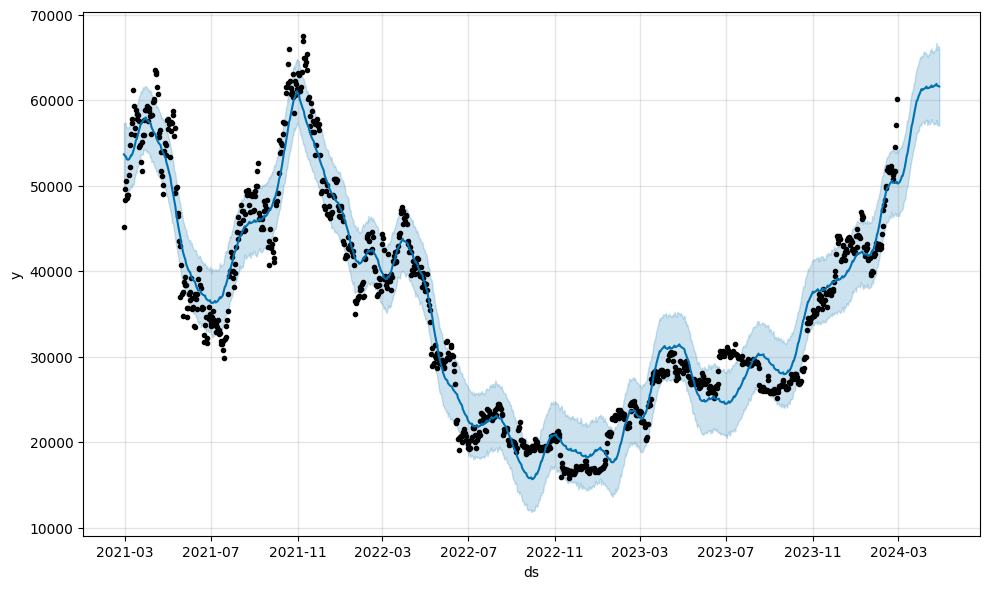

In [82]:
figure=m.plot(forecast, xlabel='ds', ylabel='y')

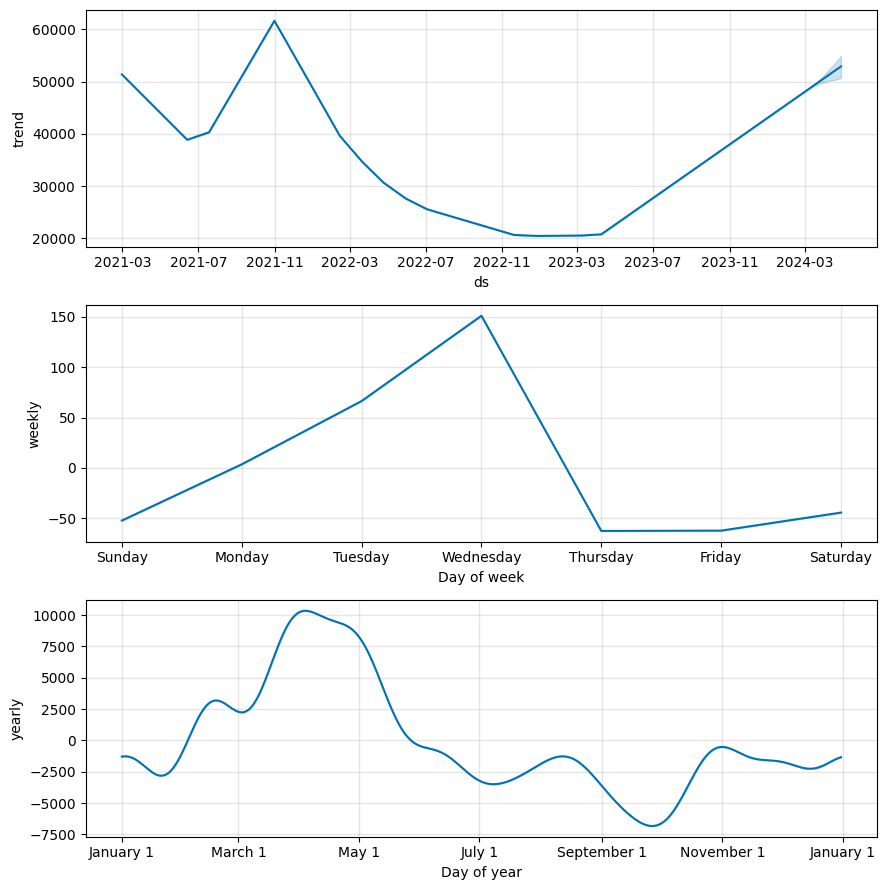

In [83]:
figure2=m.plot_components(forecast)

##Downloading the Forecast data

In [18]:
from google.colab import files
forecast.to_csv(f'{stock}_forecast.csv')
files.download(f'{stock}_forecast.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>